In [2]:
import pandas_gbq
from google.cloud import bigquery
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

client = bigquery.Client()

In [3]:
query = """
    SELECT shipping_latitude, shipping_longitude from `no-maintenance`.shopify.orders
    WHERE shipping_latitude IS NOT NULL and shipping_longitude IS NOT NULL and json_extract_scalar(shipping_address, '$.province') = 'California'
     and shipping_address IS NOT NULL
    """
df = pandas_gbq.read_gbq(query, project_id=client.project)


Downloading: 100%|██████████|


In [40]:
# Kmeans constants
NUMBER_OF_CLUSTERS = 18
NUMBER_OF_RUNS = 10
MAX_ITERATIONS = 300
RANDOM_STATE = 42

In [41]:
df

,shipping_latitude,shipping_longitude,cluster
0,33.731839,-117.999223,5
1,33.963965,-118.398497,2
2,34.125803,-118.259983,4
3,34.059252,-118.280178,4
4,34.125803,-118.259983,4
...,...,...,...
3706,37.802967,-122.233681,13
3707,34.198869,-118.474672,12
3708,34.099276,-118.274266,4
3709,34.102478,-118.291483,4


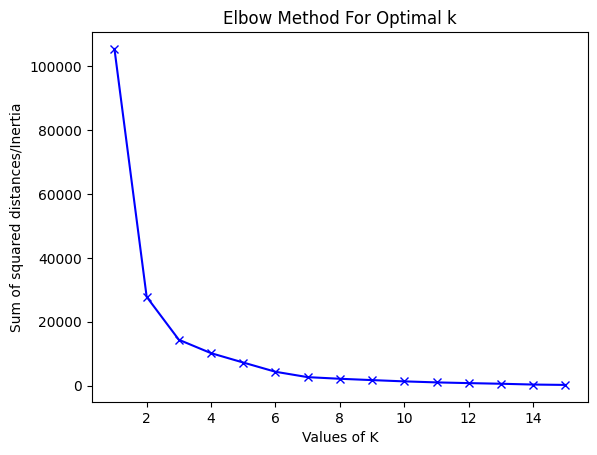

In [42]:
# Elbow curve method for evaluating if K is a good fit (SSE)
Sum_of_squared_distances = []
K = range(1,16)
for num_clusters in K :
 kmeans = KMeans(
    n_clusters=num_clusters,
    n_init=NUMBER_OF_RUNS,
    max_iter=MAX_ITERATIONS,
    random_state=RANDOM_STATE
 )
 kmeans.fit(df)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

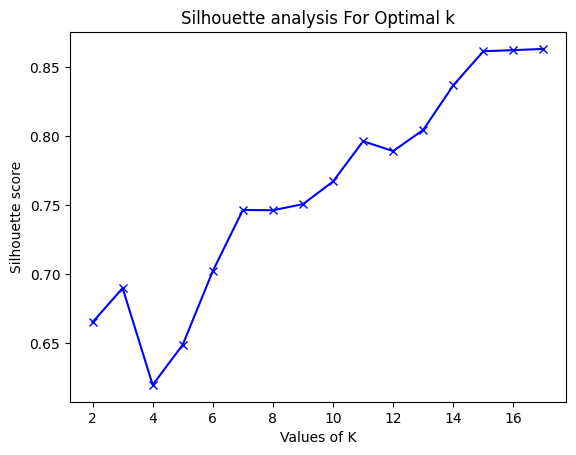

In [43]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, NUMBER_OF_CLUSTERS) if NUMBER_OF_CLUSTERS > 16 else range(2, 16)
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(
        n_clusters=num_clusters,
        n_init=NUMBER_OF_RUNS,
        max_iter=MAX_ITERATIONS,
        random_state=RANDOM_STATE
    )
    kmeans.fit(df)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(df, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [49]:
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=NUMBER_OF_CLUSTERS,
    n_init=NUMBER_OF_RUNS,
    max_iter=MAX_ITERATIONS,
    random_state=RANDOM_STATE
)

In [50]:
# do clustering
kmeans.fit(df)
# save results
labels = kmeans.labels_

In [51]:
df['cluster'] = labels
# display the number of mamber each clustering
_clusters = df.groupby('cluster').size()
print(_clusters)

cluster
0     127
1       4
2     253
3     229
4      40
5      57
6      42
7     124
8     209
9      83
10    229
11    768
12    283
13    209
14     47
15    354
16    457
17    196
dtype: int64


In [54]:
import folium
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#aec7e8", "#ffbb78",
    "#98df8a", "#ff9896", "#c5b0d5", "#c49c94",
    "#d9d9d9", "#BC80BD", "#CC6677", "#882255",
    "#44AA99", "#117733", "#999933", "#DDCC77",
    "#661100", "#AA4499"
]
lat = df.iloc[0]['shipping_latitude']
lng = df.iloc[0]['shipping_longitude']

In [55]:
map = folium.Map(location=[lat, lng], zoom_start=12)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["shipping_latitude"], row["shipping_longitude"]],
        radius=12,
        weight=2,
        fill=True,
        fill_color=colors[int(row["cluster"])],
        color=colors[int(row["cluster"])]
    ).add_to(map)
map